In [28]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from fastai.data.all import *
from fastai.vision.all import *
import PIL
from PIL import Image
from pathlib import Path
import os
from fastprogress.fastprogress import master_bar, progress_bar
from glob import glob

In [ ]:
!wget https://github.com/dizys/nyu-cv-final-project/releases/download/dataset/NYU_CV_RVAP_dataset_1.0.0.zip
!mkdir -p /content/dataset/stable_diffusion
!unzip NYU_CV_RVAP_dataset_1.0.0.zip -d /content/dataset/stable_diffusion

In [ ]:
!wget https://github.com/dizys/nyu-cv-final-project/releases/download/dataset/NYU_CV_RVAP_dalle2_dataset_1.0.0.zip
!mkdir -p /content/dataset/dalle2
!unzip NYU_CV_RVAP_dalle2_dataset_1.0.0.zip -d /content/dataset/dalle2

In [18]:
def label_func(fpath: Path):
  label = "original" if "original/" in str(fpath.absolute()) else "ai"
  return label

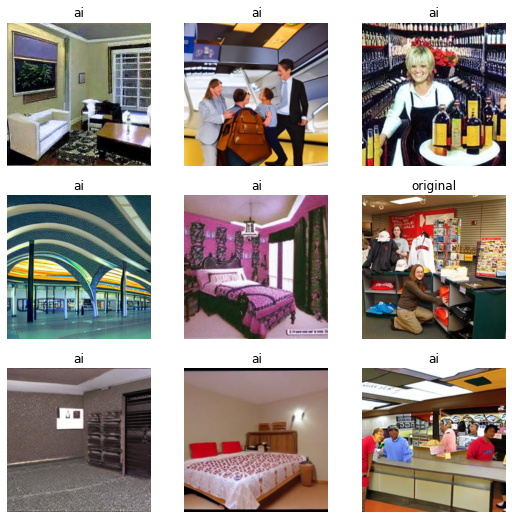

In [19]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter())

dls = dblock.dataloaders("dataset/stable_diffusion")
dls.show_batch()

In [20]:
learn = vision_learner(dls, resnet34, metrics=accuracy)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
models_path = Path("/content/drive/MyDrive/Studies/Master Studies/Fall 2022/Computer Vision/Final Project/models")

In [22]:
learn.load(models_path / "resnet34")

In [30]:
dataset_image_paths = glob("/content/dataset/dalle2/**/*")

In [46]:
dataset_total = 0
dataset_correct_prediction = 0
dataset_ai_as_original = 0
dataset_original_as_ai = 0
dataset_ai_as_ai = 0
dataset_original_as_original = 0

for image_path in progress_bar(dataset_image_paths):
  ground_truth = label_func(Path(image_path))
  result = learn.predict(image_path)
  prediction = result[0]
  dataset_total += 1
  if ground_truth == prediction:
    dataset_correct_prediction += 1
    if ground_truth == "original":
      dataset_original_as_original += 1
    else:
      dataset_ai_as_ai += 1
  else:
    if ground_truth == "original":
      dataset_original_as_ai += 1
    else:
      dataset_ai_as_original += 1

In [47]:
print(f"Accuracy: {dataset_correct_prediction}/{dataset_total} = {dataset_correct_prediction/dataset_total}")
print(f"{dataset_original_as_original} original images correctly detected.")
print(f"{dataset_ai_as_ai} ai images correctly detected.")
print(f"{dataset_original_as_ai} original images falsly detected as ai ones.")
print(f"{dataset_ai_as_original} ai images falsly detected as original ones.")

Accuracy: 309/600 = 0.515
296 original images correctly detected.
13 ai images correctly detected.
4 original images falsly detected as ai ones.
287 ai images falsly detected as original ones.
